# Census Income
---

#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Import the data file

In [2]:
raw_df = pd.read_csv('files/datasets/adult.csv')
raw_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Because values from the CSV file in Kaggle uses `?` as null values, we will replace those question marks with a NaN. 

In [3]:
raw_df.replace(to_replace='?', value=np.nan, inplace=True)

In [4]:
raw_df.replace(to_replace='<=50K', value=0, inplace=True)
raw_df.replace(to_replace='>50K', value=1, inplace=True)

#### View information about the dataframe

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


#### Split the data into target and features

In [6]:
def xy_split(dataframe, y_column):
    features = dataframe.loc[:, dataframe.columns != y_column]
    target = dataframe[y_column]
    return features, target

X, y = xy_split(raw_df, 'income')

#### Create training and testing sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Create a copy of the original dataset

In [8]:
df = X_train.copy()

---

# Data Preparation

#### Import necesary libraries

In [9]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn import set_config
set_config(transform_output="pandas")

#### Determine which columns have low cardinality

In [10]:
def ohe_eligibility(datafame):
    for i in datafame.columns:
        if len(datafame[i].value_counts()) < 10:
            print(f'{len(datafame[i].value_counts())} - {i}')
        else:
            pass
        
ohe_eligibility(df)

8 - workclass
7 - marital.status
6 - relationship
5 - race
2 - sex


In [11]:
df['marital.status'].value_counts(dropna=False)

Married-civ-spouse       11977
Never-married             8502
Divorced                  3582
Separated                  827
Widowed                    790
Married-spouse-absent      352
Married-AF-spouse           18
Name: marital.status, dtype: int64

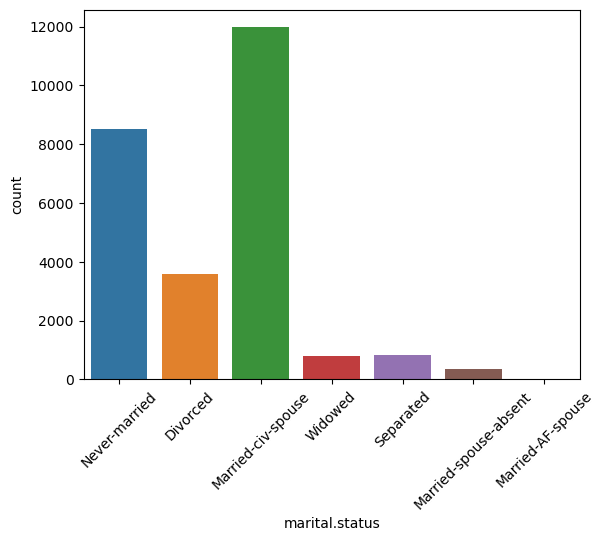

In [12]:
sns.countplot(x='marital.status', data=df)
plt.xticks(rotation=45)
plt.show()

### Next Steps (Jan 22, 2022)

* [ ] Determine the income for each marital.status

* [ ] If you can find a pattern, disregard hash encoding

* [ ] When the low values represented in marital.status is not a primary factor for income, use hash encoding

In [13]:
params = {'dataframe': raw_df,
          'feature_of_int': 'marital.status', 
          'target': 'income', 
          'Uniq_col_id': 'fnlwgt'}

def create_data(dataframe, feature_of_int, target, Uniq_col_id):
    dataframe = dataframe.groupby([feature_of_int, target]).count()
    dataframe = dataframe.drop(columns = dataframe.loc[:, ~dataframe.columns.isin([feature_of_int, target, Uniq_col_id])])
    new_df = dataframe.rename(columns={Uniq_col_id:'Count'}).transpose()
    return new_df

df_p = create_data(**params)

In [14]:
def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'Divorced':{}, 'Married-AF-spouse':{}, 
                   'Married-civ-spouse':{}, 'Married-spouse-absent':{}, 
                   'Never-married':{}, 'Separated':{}, 'Widowed':{}}
    decks = df.columns.levels[0]

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

all_surv_count, all_surv_per = get_survived_dist(df_p)

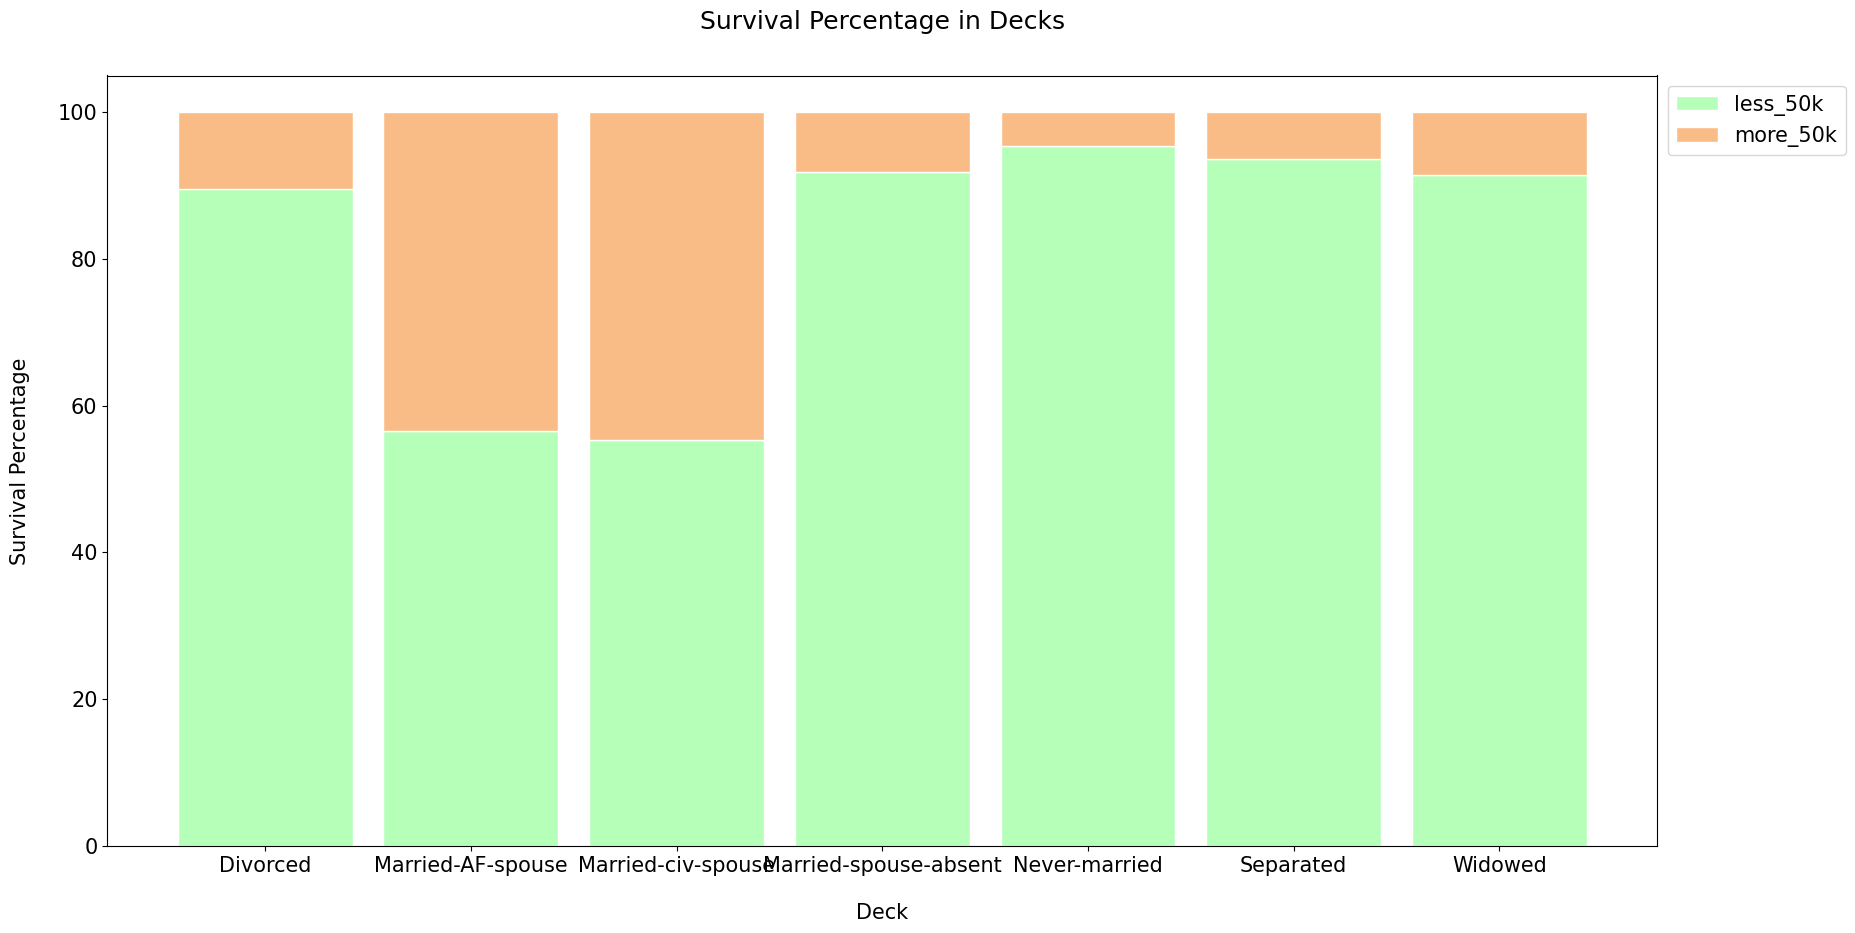

In [15]:
def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    less_50k = df_survived_percentages[0]
    more_50k = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, less_50k, color='#b5ffb9', edgecolor='white', width=bar_width, label="less_50k")
    plt.bar(bar_count, more_50k, bottom=less_50k, color='#f9bc86', edgecolor='white', width=bar_width, label="more_50k")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_p)
display_surv_dist(all_surv_per)

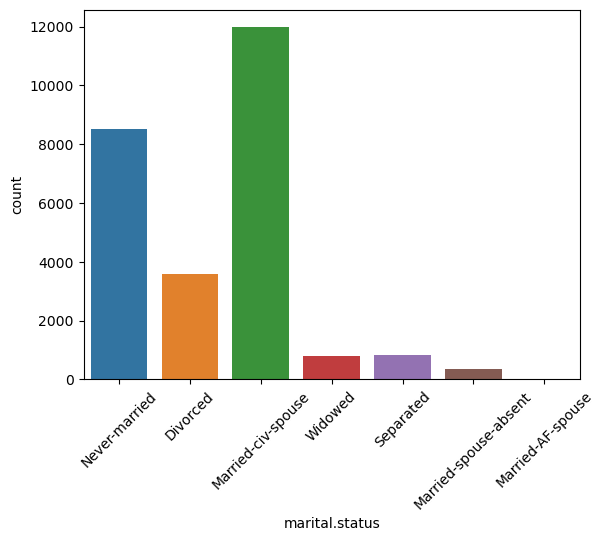

In [16]:
sns.countplot(x='marital.status', data=df)
plt.xticks(rotation=45)
plt.show()

Becuse for majority of status, the income is less than 50k, it may be acceptable to use hash encoding. Hash it in a way that Married-civ, Married-AF, are separated and the rest can be hash collided [**If that is possible**, which we will know next time].

----

In [17]:
for i in raw_df.columns:
    print(f'{i}: {len(raw_df[i].value_counts())}')

age: 73
workclass: 8
fnlwgt: 21648
education: 16
education.num: 16
marital.status: 7
occupation: 14
relationship: 6
race: 5
sex: 2
capital.gain: 119
capital.loss: 92
hours.per.week: 94
native.country: 41
income: 2


In [18]:
for i in raw_df.columns:
    print(f'{i}: {raw_df[i].isnull().sum()}')

age: 0
workclass: 1836
fnlwgt: 0
education: 0
education.num: 0
marital.status: 0
occupation: 1843
relationship: 0
race: 0
sex: 0
capital.gain: 0
capital.loss: 0
hours.per.week: 0
native.country: 583
income: 0


workclass - replace by mode <br>
occupation - replace using a machine learning method <br>
native.country - replace by mode

---

In [19]:


freq_imp = SimpleImputer(strategy="most_frequent")
ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_pipeline = make_pipeline(freq_imp, ohe_enc)

In [20]:
df['marital.status'].value_counts(dropna=False)

Married-civ-spouse       11977
Never-married             8502
Divorced                  3582
Separated                  827
Widowed                    790
Married-spouse-absent      352
Married-AF-spouse           18
Name: marital.status, dtype: int64

In [21]:
from category_encoders import CountEncoder

cnt_encoder = CountEncoder()

ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cardinality_pipeline = make_pipeline(freq_imp, cnt_encoder)

In [22]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country'],
      dtype='object')

* [ ] Age
* [ ] workclass
* [ ] fnlwght
* [ ] education
* [ ] education.num
* [ ] martial.status
* [ ] occupation
* [ ] relationship
* [ ] race
* [X] sex
* [ ] occupation
* [ ] capital.gain
* [ ] capital.loss
* [ ] hours.per.week
* [ ] native.country
* [ ] income

In [23]:
oe = OrdinalEncoder()

In [24]:
count_process = ColumnTransformer([
    ('count', cardinality_pipeline, ['relationship', 'marital.status']),
    ('ohe', ohe_enc, ['sex'])
])

In [25]:
df['workclass'].isnull().sum()

1436

In [26]:
count_process.fit_transform(df)

,count__relationship,count__marital.status,ohe__sex_Female,ohe__sex_Male
5514,6623,8502,0.0,1.0
19777,6623,8502,1.0,0.0
10781,2770,3582,1.0,0.0
32240,1248,11977,1.0,0.0
9876,10560,11977,0.0,1.0
...,...,...,...,...
29802,4051,8502,0.0,1.0
5390,10560,11977,0.0,1.0
860,10560,11977,0.0,1.0
15795,10560,11977,0.0,1.0


----

In [27]:
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
5514,26,Private,256263,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,25,United-States
19777,24,Private,170277,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States
10781,36,Private,75826,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32240,22,State-gov,24395,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States
9876,31,Local-gov,356689,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,25,Private,410240,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States
5390,51,Private,146767,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States
860,55,Federal-gov,238192,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,1887,40,United-States
15795,41,Private,154076,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,50,United-States


---